Marysa M. Laguë

2019.09.19

# ACDC "Weird World"

### Analysis of ISCA runs by Marianne Pietschnig 

#### Run descriptions:
<update this>

In [1]:
%matplotlib inline
import sys
sys.path.append('./scripts')

# netcdf/numpy/xarray
import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
import pickle as pickle
from sklearn import linear_model
import numpy.ma as ma
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing



import time

from copy import copy 

#from joblib import Parallel, delayed
import multiprocessing

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
#import brewer2mpl as cbrew
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter

from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size

from mpl_toolkits.axes_grid1 import make_axes_locatable

# from matplotlib.gridspec import GridSpec
#import matplotlib.gridspec as gridspec
from matplotlib import gridspec

# OS interaction
import os
import sys
import cftime

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

#from season_mean import season_mean

import matplotlib.colors as mcolors

import glob

In [2]:

def NE_flux_zonal_new(area_grid,lat,lon,FSNT,FLNT):

    area = area_grid

    #if stats == False:
    # Define toa energy imbalance/residual as shortwave - longwave
    # multiply by energy to work in clean watts
    Rtoa = (FSNT - FLNT) * area

    # spaces between lats and lons
    dlat = np.array(np.diff(lat))
    dlat = np.append(dlat, dlat[-1])
    dlon = np.array(np.diff(lon))
    dlon = np.append(dlon, dlon[-1])

    # create empty flux matrix to fill in
    flux = np.zeros([np.shape(lat)[0], np.shape(lon)[0]])

    # Loop over latitudes and sum energy
    for k in range(np.shape(lat)[0]):
        # sum energy of southern lats up to that lat
        for r in range(k):
            flux[k, :] = flux[k, :] + Rtoa[r, :]

    # calculate how much we overshot zero at the north pole
    imbal = flux[-1, :]
    imbal_mat = imbal / np.shape(lat)[0] * np.ones([np.shape(lat)[0], np.shape(lon)[0]])

    # modify Rtoa to account for discrete step sizes & overshoot
    Rtoa_mod = Rtoa - imbal_mat

    # re-calculate flux
    flux_mod = np.zeros([np.shape(lat)[0], np.shape(lon)[0]])
    for k in range(np.shape(lat)[0]):
        for r in range(k):
            flux_mod[k, :] = flux_mod[k, :] + Rtoa_mod[r, :]

    # Put back into W/m2 by dividing by area
    # NE_flux = flux_mod / area
    NE_flux = flux_mod * 10 ** (-15)
    NE_flux_zonal_out = np.sum(NE_flux,1)
    
    return NE_flux_zonal_out





In [3]:

def quick_map(mapdata,lat,lon,title=None,cb_ttl=None,cmap=None,clim=None,
              filepath=None,show=None,sigmask=None,p=None,
              do_zonal=None,
              outside_color = None, outside_val = None):
    
    if do_zonal==1:
        # make 2 subplots, one for map, one for zonal average next to it
        fig = plt.figure(figsize=(8,7))
    else:
        fig = plt.figure(figsize=(8,7))
    
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

    #cs = plt.contourf(cyclic_lons,lat,cyclic_data,60,transform=ccrs.PlateCarree(),extend='both')#,vmin=clim[0],vmax=clim[1])
    cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
    

    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)
    
#     cmap = plt.get_cmap()
#     cmap.set_bad(color='black')
   
    
    if title:
        plt.title(title,fontsize=16,y=1.05)
        
    if clim:
        plt.clim(clim)  
        cs.set_clim(clim[0],clim[1])
        cs.set_clim(clim)
        
    cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
    cbar.ax.tick_params(labelsize=14) 
    
    if clim:
        cbar.set_clim(clim)

    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=14)
    
#     # If outside_val and outside_color, check if pos (set_over) or neg (set_under) to outside_color:
#     if outside_val:
#         cm = plt.get_cmap()
#         if outside_val=='left':
#             cm.set_under(color=outside_color)
#         elif outside_val=='right':
#             cm.set_over(color=outside_color)
#         else:
#             a=9# garbarge filler...
#     else:
#         cm=0.0
    cm = plt.get_cmap()
   
    # add hatching for significance
    if p:
        cyclic_sig, cyclic_lons = add_cyclic_point(sigmask,coord=lon)
        #hatch = plt.pcolor(cyclic_lons,lat,cyclic_sig,hatch='xxx',alpha=0.,transform=ccrs.PlateCarree()); 

        CLN, CLT = np.meshgrid(cyclic_lons,lat)

        # only put the hatches where the sigmask is >0.5
        #cyclic_sig = np.ma.masked_where(cyclic_sig<p,cyclic_sig)
        lat_sig = np.ma.masked_where(cyclic_sig<p,CLT)
        lat_sig = np.ma.masked_where(np.isnan(cyclic_sig),lat_sig)
        lon_sig = np.ma.masked_where(cyclic_sig<p,CLN)
        lon_sig = np.ma.masked_where(np.isnan(cyclic_sig),lon_sig)

        hatch = ax.scatter(lon_sig,lat_sig,marker='x',s=2,c=[0.6, 0.6, 0.6],alpha=0.8,transform=ccrs.PlateCarree(),)

    ax.patch.set_alpha(0.0)
    
    if show:
        plt.show()
    
    if filepath:
        # save figure if path given
        fig.savefig(filepath+'.png',dpi=300,facecolor=None,edgecolor=None,bbox_inches='tight',transparent=True,pad_inches=0.01)
        
    plt.close()
    
    return fig,ax,cs,cbar,cm



In [4]:

def map_with_zonal(mapdata,lat,lon,title=None,cb_ttl=None,cmap=None,clim=None,
              filepath=None,show=None,sigmask=None,p=None,
              do_zonal=None,zonal_range=None):
    

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

    
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[7,1], height_ratios=[10,1])
    #ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson())
    #ax2 = plt.subplot(gs[0,1])
    #cbar_ax = plt.subplot(gs[1,0])
    # gs.tight_layout(plt.gcf(),pad=5,h_pad=5.2, w_pad=0.3, )


    
       
        
        
    ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson())
    # plot the pcolor map
    #ax1.coastlines()
    ax1.set_global()
    cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
    ax1.set_aspect(1)

    if title:
        plt.title(title,fontsize=16,y=1.05)
    
    if clim:
        plt.clim(clim)  
        cs.set_clim(clim[0],clim[1])
        cs.set_clim(clim)
     
    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)

    # add hatching for significance
    if p:
        cyclic_sig, cyclic_lons = add_cyclic_point(sigmask,coord=lon)
        #hatch = plt.pcolor(cyclic_lons,lat,cyclic_sig,hatch='xxx',alpha=0.,transform=ccrs.PlateCarree()); 

        CLN, CLT = np.meshgrid(cyclic_lons,lat)

        # only put the hatches where the sigmask is >0.5
        #cyclic_sig = np.ma.masked_where(cyclic_sig<p,cyclic_sig)
        lat_sig = np.ma.masked_where(cyclic_sig<p,CLT)
        lat_sig = np.ma.masked_where(np.isnan(cyclic_sig),lat_sig)
        lon_sig = np.ma.masked_where(cyclic_sig<p,CLN)
        lon_sig = np.ma.masked_where(np.isnan(cyclic_sig),lon_sig)

        hatch = ax1.scatter(lon_sig,lat_sig,marker='x',s=2,c=[0.6, 0.6, 0.6],alpha=0.8,transform=ccrs.PlateCarree(),)

    
    # plot the colorbar
    cbar_ax = plt.subplot(gs[1,0])
    cbar = plt.colorbar(ax=cbar_ax,orientation='horizontal',extend='both',pad=-5, shrink=0.5,cax=cbar_ax)

    cbar.ax.tick_params(labelsize=14) 
    
    if clim:
        cbar.set_clim(clim)

    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=14)
        
     

    # plot the zonal mean:
    ax2 = plt.subplot(gs[0,1])
    ax2.plot([0,0],[-90,90],'k--',linewidth=1)
    zplt = ax2.plot(np.nanmean(cyclic_data,1),lat)
    plt.ylabel('latitude',fontsize=14)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylim([-90,90])
    ax2.tick_params(labelsize=12) 
    # ax2.grid()
    # plt.yticks([-90,-75,-60,-45,-30,-15,0,15,30,45,60,75,90])
    plt.yticks([-90,-60,-30,0,30,60,90])
    plt.xlabel(cb_ttl,fontsize=12)
    
    if zonal_range:
        plt.xlim(zonal_range)



    # get height of map projection 
    ax1.apply_aspect() # this is necessary to not get the bounding box projection
    print(ax1.get_position())
    ax1_pos = ax1.get_position()
    y0 = ax1_pos.y0
    hght = ax1_pos.height

    ax2_pos0 = ax2.get_position()
    ax2_pos_new = [ax2_pos0.x0-0.04, y0, ax2_pos0.width, hght]
    ax2.set_position(ax2_pos_new,which='both')

    # manually move cbar up
    cbar_pos = cbar_ax.get_position()
    # new_pos = [ax1_pos.x0+0.05,y0-0.06,ax1_pos.width-0.1,cbar_pos.height/2]
    new_pos = [ax1_pos.x0,y0-0.06,ax1_pos.width,cbar_pos.height/2]
    cbar_ax.set_position(new_pos)
    
    cm = plt.get_cmap()
   
    
    ax1.patch.set_alpha(0.0)
    ax2.patch.set_alpha(0.0)
    cbar_ax.patch.set_alpha(0.0)
    
    if show:
        plt.show()
    
    if filepath:
        # save figure if path given
        fig.savefig(filepath+'.png',dpi=300,facecolor=None,edgecolor=None,bbox_inches='tight',transparent=True,pad_inches=0.01)
        
    plt.close()
    
    return fig,ax1,cs,cbar_ax,cm,ax2


In [5]:
#xr.set_options(enable_cftimeindex=True)


In [6]:
isca_outpath = '/Users/mlague/GoogleDrive/School/Research/ACDC/ISCA/'
case = 'half_ocean_newbucket_0qflux_ctl'

filelist = glob.glob(isca_outpath + case + '/*/*.nc')
filelist.sort()

In [7]:
with xr.set_options(enable_cftimeindex=True):
    ds_ctrl_long = xr.open_mfdataset(filelist,autoclose='true',decode_times=False)

time0 = ds_ctrl_long['time']
# time2 = nc.num2date(ds_ctrl['time'][:], units=ds_ctrl['time'].units,
#                             calendar=ds_ctrl['time'].calendar,only_use_cftime_datetimes=True)

time2 = cftime.num2date(ds_ctrl_long['time'][:], units=ds_ctrl_long['time'].units,
                            calendar=ds_ctrl_long['time'].calendar,only_use_cftime_datetimes=True)

ds_ctrl_long['time'].values = time2

# ds_spunup = ds_ctrl.sel('')

#ds_ctrl = ds_ctrl_long.loc[dict(time=slice(time2[97],time2[125]))]
# Drop everything before the 9th year
ds_ctrl = ds_ctrl_long.where(ds_ctrl_long['time'].dt.year.isin(range(5,9)),drop=True)

ds_clim = ds_ctrl.groupby('time.month').mean('time')

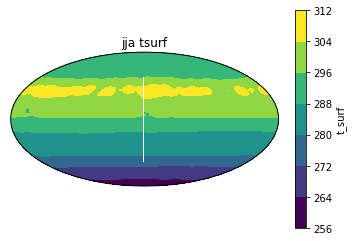

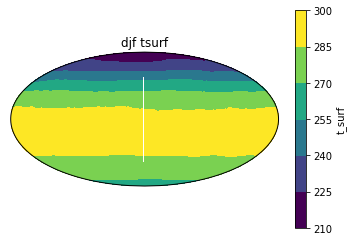

In [8]:
# ts_sea = ds_ctrl['t_surf'].groupby('time.season')
# data = ts_sea.sel(season='JJA')
#dict(ds_lib['rcp85']['albedo']['albedo'].groupby('time.season'))['SON'].values[:]
jja = dict(ds_ctrl['t_surf'].groupby('time.season'))['JJA'].mean('time')#.values[:]
djf = dict(ds_ctrl['t_surf'].groupby('time.season'))['DJF'].mean('time')#.values[:]


# plt.imshow(jja,clim=[240,300]);plt.colorbar();plt.title('JJA');plt.show();

# plt.imshow(djf,clim=[240,300]);plt.colorbar();plt.title('djf');plt.show();

ax = plt.axes(projection=ccrs.Mollweide())
jja.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.set_global()
# ax.title('jja tsurf')
# ax.coastlines()
plt.title('jja tsurf')
plt.show()

ax = plt.axes(projection=ccrs.Mollweide())
djf.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.set_global()
# ax.title('djf tsurf')
# ax.coastlines()
plt.title('djf tsurf')
plt.show()




In [9]:
# anomalies.plot(col='time', col_wrap=4)

In [10]:
#ds_ctrl = xr.open_mfdataset(filelist,autoclose='true')

lat = ds_ctrl['lat'].values[:]
lon = ds_ctrl['lon'].values[:]
lev = ds_ctrl['pfull'].values[:]
time = ds_ctrl['time']

NameError: name 'var' is not defined

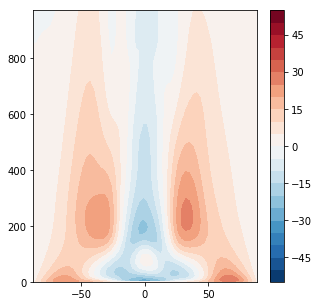

In [11]:
u_lev = np.array([-55,-50,-45, -40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55])

u_zonal = ds_ctrl['ucomp'].mean('lon').mean('time').values[:]

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.contourf(lat,lev,u_zonal,u_lev,cmap=plt.cm.RdBu_r)
cb = plt.colorbar()
cb.set_label(var + ' ' + ds_ctrl[var].units)
plt.gca().invert_yaxis()
plt.title('Zonal mean wind, ctrl \n annual')

# plot seasons!

var = 'ucomp'

jja = dict(ds_ctrl[var].groupby('time.season'))['JJA'].mean('time').mean('lon')
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.contourf(lat,lev,jja,u_lev,cmap=plt.cm.RdBu_r)
cb = plt.colorbar()
cb.set_label(var + ' ' + ds_ctrl[var].units)
plt.gca().invert_yaxis()
plt.title('Zonal mean wind, ctrl \n JJA')

djf = dict(ds_ctrl[var].groupby('time.season'))['DJF'].mean('time').mean('lon')
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
#plt.pcolormesh(lat,np.flipud(lev),jja,cmap=plt.cm.RdBu_r)
plt.contourf(lat,lev,djf,u_lev,cmap=plt.cm.RdBu_r)
cb = plt.colorbar()
cb.set_label(var + ' ' + ds_ctrl[var].units)
plt.gca().invert_yaxis()
plt.title('Zonal mean wind, ctrl \n DJF')


# djf = dict(ds_ctrl[var].groupby('time.season'))['DJF'].mean('time').mean('lon')
# fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# #plt.pcolormesh(lat,np.flipud(lev),jja,cmap=plt.cm.RdBu_r)
# plt.contourf(lat,lev,jja,u_lev,cmap=plt.cm.RdBu_r)
# cb = plt.colorbar()
# cb.set_label(var + ' ' + ds_ctrl[var].units)
# plt.gca().invert_yaxis()
# plt.title('Zonal mean wind, ctrl \n DJF')


In [ ]:
var = 'height'
data = ds_clim[var].mean('month').mean('lon')
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
#plt.pcolormesh(lat,np.flipud(lev),data,cmap=plt.cm.viridis)
plt.contourf(lat,lev,data,cmap=plt.cm.RdBu_r)
cb = plt.colorbar()
cb.set_label(var )#+ ' ' + ds_clim[var].units)
plt.gca().invert_yaxis()
plt.title('Zonal mean wind, ctrl \n annual')


Difference between northerna and southern hemisphere zonal winds:

In [ ]:
# du = u_zonal[:,32:65] - np.fliplr(u_zonal[:,0:32])
# plt.pcolormesh(du,cmap=plt.cm.RdBu_r)
# plt.colorbar()
# plt.clim([-6,6])
# plt.title('difference at each latitude (N-S) in zonal wind')

# # add countours of zonal mean wind for NH ... or for SH

In [ ]:
var = 't_surf'

mapdata = ds_ctrl[var].mean('time').values[:]


ax = plt.axes(projection=ccrs.Robinson())
#ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

LN,LT = np.meshgrid(lon,lat)

# cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
cs = plt.pcolormesh(LN,LT,mapdata,transform=ccrs.PlateCarree())

plt.set_cmap(copy(plt.cm.viridis))

plt.title(var,fontsize=16,y=1.05)
#plt.clim([240,300])

#     if clim:
#         plt.clim(clim)  
#         cs.set_clim(clim[0],clim[1])
#         cs.set_clim(clim)

cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(ds_ctrl[var].units)

#cbar.set_clim(clim)

cm = plt.get_cmap()




In [ ]:
var = 'precipitation'

mapdata = ds_ctrl[var].mean('time').values[:]


ax = plt.axes(projection=ccrs.Robinson())
#ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

LN,LT = np.meshgrid(lon,lat)

# cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
cs = plt.pcolormesh(LN,LT,mapdata,transform=ccrs.PlateCarree())

plt.set_cmap(copy(plt.cm.viridis))

plt.title(var,fontsize=16,y=1.05)
#plt.clim([240,300])

#     if clim:
#         plt.clim(clim)  
#         cs.set_clim(clim[0],clim[1])
#         cs.set_clim(clim)

cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(ds_ctrl[var].units)

#cbar.set_clim(clim)

cm = plt.get_cmap()




Check where annaul mean precip peaks - 18S would be 0.2 PW per 1.65 degree shift of latitude -> expect 18 degrees for 3 PW ... check Aaron's paper!!! 

Storms: look at variance of 700hpa omega to get idea of where strom track is
find the land strom track
See if it can move moisture into high lats - is the high lat mositure a local self supporting thing, or is the hadley circ moving moisture into the arctic during summer/spring.

If we initialized bone dry, it might stay dry... 

annual avg P and annual avg E as a fn of lattidue -> if they balance, probably no transport .

In [ ]:
var = 't_surf'
t_ts = ds_clim[var].mean('lat').mean('lon')

plt.plot(t_ts)



In [ ]:
var = 't_surf'
data = ds_clim[var].values[:]

NH_ts = ds_clim[var].loc[dict(lat=lat[(lat>0)])].mean('lat').mean('lon')
#np.mean(np.mean(data[:,32:65,:],2),1)
SH_ts = ds_clim[var].loc[dict(lat=lat[(lat<0)])].mean('lat').mean('lon')
#np.mean(np.mean(data[:,0:32,:],2),1)


plt.plot(SH_ts,'b',label='SH')
plt.plot(NH_ts,'g',label='NH')
plt.title(var + ' annual cycle')
plt.legend()



In [ ]:
data = ds_ctrl['t_surf'].values[:]
data_ts = np.mean(np.mean(data,2),1)
plt.plot(data_ts)

Write function to calculate northwards energy flux from TOA net energy fluxes

NE flux:

In [ ]:
# needs area of gridcell. 

lat_b = ds_ctrl['latb'].values[:]
lon_b = ds_ctrl['lonb'].values[:]


dlon = lon_b[30] - lon_b[29] #(lon[3]-lon[2])*np.ones(np.shape(lat))

earth_radius = 6371000  #meters
area_lat =  earth_radius**2 * np.abs(np.sin(lat_b[1:65]*np.pi/180.) - np.sin(lat_b[0:64]*np.pi/180.)) * (dlon * np.pi/180)


area_grid = np.tile(area_lat,(128,1)).transpose()

total_area = np.sum(area_grid)
                    

In [ ]:
# annual mean:
NE_flux_ctrl = {}


FSNT = ds_clim['toa_sw'].mean('month').values[:]
#np.mean(np.mean(data[:,32:65,:],2),1)
FLNT = ds_clim['olr'].mean('month').values[:]
#np.mean(np.mean(data[:,0:32,:],2),1)

#NE_flux_ctrl_ann = NE_flux_zonal(lat, lon, FSNT, FLNT, area_grid)

In [ ]:
FSNT = ds_clim['toa_sw'].mean('month').values[:]
#np.mean(np.mean(data[:,32:65,:],2),1)
FLNT = ds_clim['olr'].mean('month').values[:]

NE_flux_ctrl_ann = NE_flux_zonal_new(area_grid,lat, lon, FSNT, FLNT)


fsnt = ds_ctrl['toa_sw'].where(ds_ctrl['time'].dt.year==5,drop=True).mean('time').values[:]
flnt = ds_ctrl['olr'].where(ds_ctrl['time'].dt.year==5,drop=True).mean('time').values[:]
NE_flux_ctrl_ann5 = NE_flux_zonal_new(area_grid,lat, lon, fsnt, flnt)

fsnt = ds_ctrl['toa_sw'].where(ds_ctrl['time'].dt.year==6,drop=True).mean('time').values[:]
flnt = ds_ctrl['olr'].where(ds_ctrl['time'].dt.year==6,drop=True).mean('time').values[:]
NE_flux_ctrl_ann6 = NE_flux_zonal_new(area_grid,lat, lon, fsnt, flnt)

fsnt = ds_ctrl['toa_sw'].where(ds_ctrl['time'].dt.year==7,drop=True).mean('time').values[:]
flnt = ds_ctrl['olr'].where(ds_ctrl['time'].dt.year==7,drop=True).mean('time').values[:]
NE_flux_ctrl_ann7 = NE_flux_zonal_new(area_grid,lat, lon, fsnt, flnt)

fsnt = ds_ctrl['toa_sw'].where(ds_ctrl['time'].dt.year==8,drop=True).mean('time').values[:]
flnt = ds_ctrl['olr'].where(ds_ctrl['time'].dt.year==8,drop=True).mean('time').values[:]
NE_flux_ctrl_ann8 = NE_flux_zonal_new(area_grid,lat, lon, fsnt, flnt)


fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.gca()
# light yearly NE flux
plt.plot(np.sin(lat*np.pi/180), NE_flux_ctrl_ann5,color=[.8,.8,.8])
plt.plot(np.sin(lat*np.pi/180), NE_flux_ctrl_ann6,color=[.8,.8,.8])
plt.plot(np.sin(lat*np.pi/180), NE_flux_ctrl_ann7,color=[.8,.8,.8])
plt.plot(np.sin(lat*np.pi/180), NE_flux_ctrl_ann8,color=[.8,.8,.8])
# Mean NEflux
plt.plot(np.sin(lat*np.pi/180), NE_flux_ctrl_ann)
ax.set_ylabel('NE Flux in PW',FontSize=14)
ax.set_xlabel('latitude [degrees]',FontSize=14)
xlim = ax.get_xlim()
xline = [np.sin(xlim[0]*np.pi/180), np.sin(xlim[1]*np.pi/180)]
#ylim = [0, 0]
plt.plot([-1,1], [0, 0], linestyle='dashed', color='gray')
plt.plot([0,0],[-3.5,3.5],linestyle='dashed',color='gray')
ax = plt.gca()
ax.set_xlim([-1,1])
xtick_ttl = np.array([-90, -60,  -30, -15, 0, 15, 30 , 60, 90]).transpose()
xtick_val = np.sin(xtick_ttl*np.pi/180)
ax.set_xticks(xtick_val)
ax.set_xticklabels(xtick_ttl,fontsize=12)
#plt.plot.tick_params(fontsize=12,axis='both')
#ax.tick_params(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
#cross_eq:
cross_eq = np.mean(NE_flux_ctrl_ann[31:33])

plt.title('Northwards Energy Transport, Northland Control \n Cross-eq Flux = ' + np.str(np.around(cross_eq,2)) +' PW',FontSize=16)
plt.show()
plt.close()

Expect lower total heat transport because the albedo difference between the hemispheres in these experiments are smaller tha nthe albeod difference s in the real world. The Northern hemisphere here has an albedo brighter than the southern hemispehre (ocean), so heat transport goes north, but in the real world the poles are even brighter than the equator, so there is an extra energy deficit near the poles (~1/3 of heat transport is due to this) in the real world that we don't have here. So we expect a 1/3 reduction (ish) in heat tranport peak. Which is why we have a peak of roughly 3 PW rather than 5 or 6 i nthe real world. 

W could design a world with a really bright trppics, really dark poles, suc hthat the same solar is absorbed everywehre and we would expect no energy transport. 

Southern hemisphere heat transport peaks at 45S ish as we would expect in the real world. In the NH, peaks much futher towards the tropics. 
Shape of NH transport is differnt, so its probably differnt processes

Look at 700hpa or 850 omega daily variance to get an idea of where eddies are biggest (should match up with SH max of heat transport)

In [ ]:
# Surface energy budget
fsns = ds_clim['flux_sw'].mean('month').mean('lon').values[:]
flns = ds_clim['flux_lw'].mean('month').mean('lon').values[:]
shflx = ds_clim['flux_t'].mean('month').mean('lon').values[:]
lhflx = ds_clim['flux_lhe'].mean('month').mean('lon').values[:]


fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.gca()
# light yearly NE flux
plt.plot(np.sin(lat*np.pi/180), fsns,color='g',linestyle='--',label='net surface SW')
plt.plot(np.sin(lat*np.pi/180), flns,color='m',linestyle=':',label='net surface LW')
plt.plot(np.sin(lat*np.pi/180), shflx,color='r',label='net surface SH')
plt.plot(np.sin(lat*np.pi/180), lhflx,color='b',label='net surface LH')

ax.set_ylabel('Surface Energy Flux [W/m2]',FontSize=14)
ax.set_xlabel('latitude [degrees]',FontSize=14)
xlim = ax.get_xlim()
xline = [np.sin(xlim[0]*np.pi/180), np.sin(xlim[1]*np.pi/180)]
ylim = ax.get_ylim()
plt.plot([-1,1], [0, 0], linestyle='dashed', color='gray')
plt.plot([0,0],[ylim[0],ylim[1]],linestyle='dashed',color='gray')
ax.set_ylim([ylim[0],ylim[1]])
ax.set_xlim([-1,1])
xtick_ttl = np.array([-90, -60,  -30, -15, 0, 15, 30 , 60, 90]).transpose()
xtick_val = np.sin(xtick_ttl*np.pi/180)
ax.set_xticks(xtick_val)
ax.set_xticklabels(xtick_ttl,fontsize=12)
#plt.plot.tick_params(fontsize=12,axis='both')
#ax.tick_params(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.title('Annual mean surface energy fluxes, Northland Control \n ' 
          + '(zonal mean)',FontSize=16)
plt.legend()
plt.show()
plt.close()

## Vairance of 700 hpa omega for strom tracks (need daily)

In [12]:
ds_ctrl = ds_ctrl_long.where(ds_ctrl_long['time'].dt.year.isin(range(5,9)),drop=True)


djf700 = ds_ctrl['omega'].where(ds_ctrl['time'].dt.month.isin([1,2,12]),drop=True).sel(pfull=700,method='nearest')
jja700 = ds_ctrl['omega'].where(ds_ctrl['time'].dt.month.isin([6,7,8]),drop=True).sel(pfull=700,method='nearest')
ann700 = ds_ctrl['omega'].sel(pfull=700,method='nearest')

djf700_var = np.var(djf700.values[:],0)
jja700_var = np.var(jja700.values[:],0)
ann700_var = np.var(ann700.values[:],0)



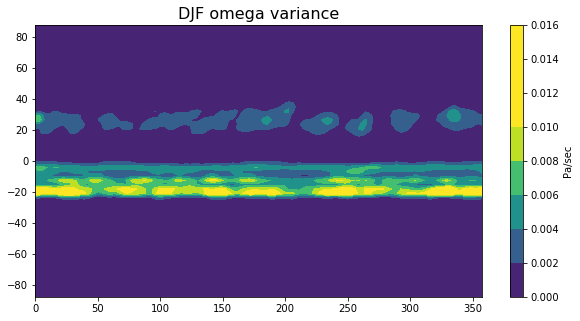

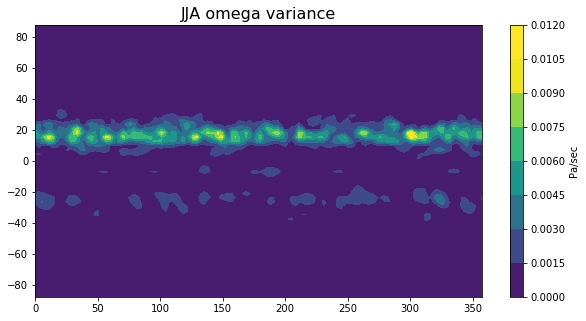

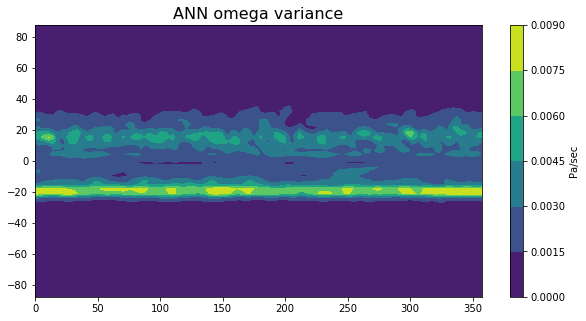

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.gca()
# light yearly NE flux
plt.contourf(lon,lat, djf700_var)
cb = plt.colorbar()
cb.set_label(ds_ctrl['omega'].units)
cb.set_clim([0,0.01])
plt.clim([0,.01])
plt.title('DJF omega variance',FontSize=16)
plt.show()
plt.close()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.gca()
# light yearly NE flux
plt.contourf(lon,lat, jja700_var)
cb = plt.colorbar()
cb.set_label(ds_ctrl['omega'].units)
cb.set_clim([0,0.01])
plt.clim([0,.01])
plt.title('JJA omega variance',FontSize=16)
plt.show()
plt.close()


fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.gca()
# light yearly NE flux
plt.contourf(lon,lat, ann700_var,clim=[0,0.01])
cb = plt.colorbar()
cb.set_label(ds_ctrl['omega'].units)
# cb.set_clim([0,0.01])
plt.title('ANN omega variance',FontSize=16)
plt.show()
plt.close()

Make nicer polar plots. For now, keep global, but make nicer...

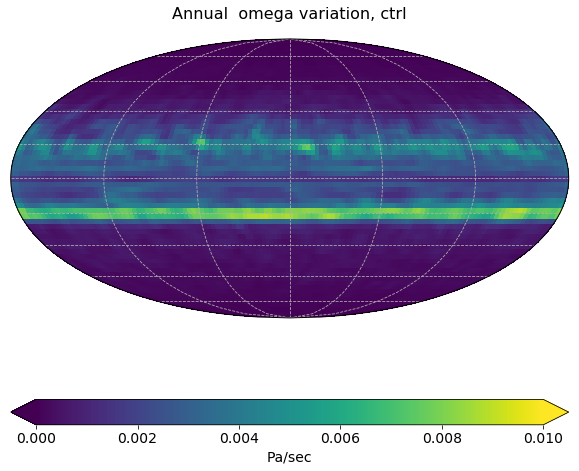

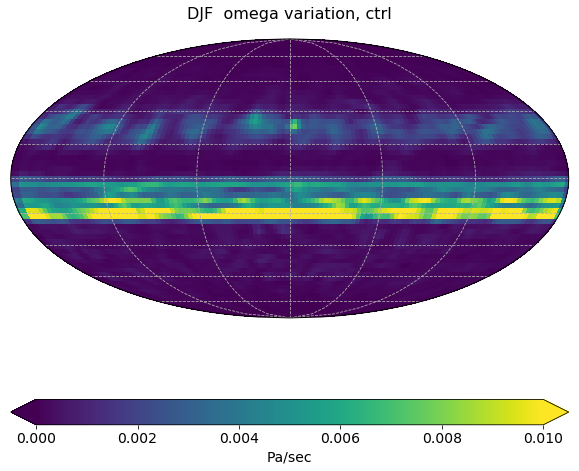

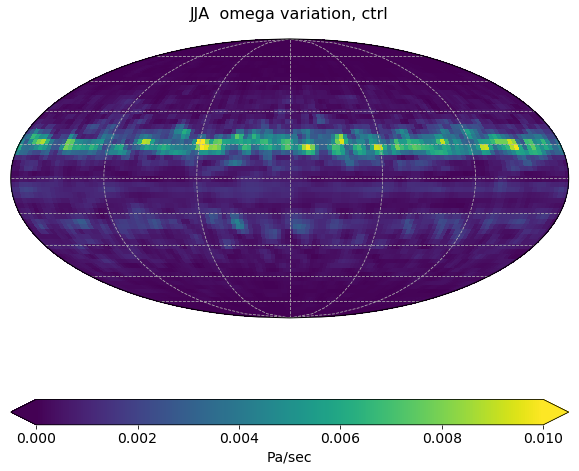

In [14]:
mapdata = ann700_var
cb_ttl = ds_ctrl['omega'].units
title = 'Annual  omega variation, ctrl'
clim=[0,0.01]



cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(projection=ccrs.Mollweide())
# plot the pcolor map
#ax1.coastlines()
ax1.set_global()
cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
ax1.set_aspect(1)
plt.title(title,fontsize=16,y=1.05)
plt.clim(clim)  
cs.set_clim(clim[0],clim[1])
cs.set_clim(clim)

plt.set_cmap(plt.cm.viridis)
ax1.gridlines(linestyle='--')#,draw_labels=True)
#gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
# plot the colorbar
# cbar_ax = plt.subplot(gs[1,0])
cbar = plt.colorbar(ax=ax1,orientation='horizontal',extend='both')#,pad=-5, 
                    #shrink=0.5,cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_clim(clim)
cbar.set_label(cb_ttl,fontsize=14)



mapdata = djf700_var
cb_ttl = ds_ctrl['omega'].units
title = 'DJF  omega variation, ctrl'
clim=[0,0.01]



cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(projection=ccrs.Mollweide())
# plot the pcolor map
#ax1.coastlines()
ax1.set_global()
cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
ax1.set_aspect(1)
plt.title(title,fontsize=16,y=1.05)
plt.clim(clim)  
cs.set_clim(clim[0],clim[1])
cs.set_clim(clim)
ax1.gridlines(linestyle='--')#,draw_labels=True)
#gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.set_cmap(plt.cm.viridis)

# plot the colorbar
# cbar_ax = plt.subplot(gs[1,0])
cbar = plt.colorbar(ax=ax1,orientation='horizontal',extend='both')#,pad=-5, 
                    #shrink=0.5,cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_clim(clim)
cbar.set_label(cb_ttl,fontsize=14)


mapdata = jja700_var
cb_ttl = ds_ctrl['omega'].units
title = 'JJA  omega variation, ctrl'
clim=[0,0.01]



cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(projection=ccrs.Mollweide())
# plot the pcolor map
#ax1.coastlines()
ax1.set_global()
cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
ax1.set_aspect(1)
ax1.gridlines(linestyle='--')#,draw_labels=True)
#gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.title(title,fontsize=16,y=1.05)
plt.clim(clim)  
cs.set_clim(clim[0],clim[1])
cs.set_clim(clim)

plt.set_cmap(plt.cm.viridis)

# plot the colorbar
# cbar_ax = plt.subplot(gs[1,0])
cbar = plt.colorbar(ax=ax1,orientation='horizontal',extend='both')#,pad=-5, 
                    #shrink=0.5,cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_clim(clim)
cbar.set_label(cb_ttl,fontsize=14)


NameError: name 'zonal_range' is not defined

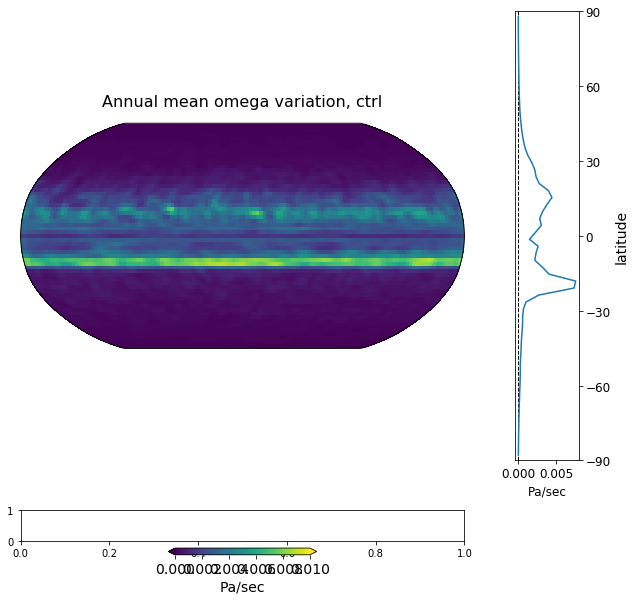

In [15]:
mapdata = ann700_var
cb_ttl = ds_ctrl['omega'].units
title = 'Annual mean omega variation, ctrl'
clim=[0,0.01]

cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)


fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[7,1], height_ratios=[10,1])

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson())
# plot the pcolor map
#ax1.coastlines()
ax1.set_global()
cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
ax1.set_aspect(1)
plt.title(title,fontsize=16,y=1.05)
plt.clim(clim)  
cs.set_clim(clim[0],clim[1])
cs.set_clim(clim)

plt.set_cmap(plt.cm.viridis)

# plot the colorbar
cbar_ax = plt.subplot(gs[1,0])
cbar = plt.colorbar(ax=cbar_ax,orientation='horizontal',extend='both')#,#pad=-5, 
                    #shrink=0.5,cax=cbar_ax)
cbar.ax.tick_params(labelsize=14) 
cbar.set_clim(clim)
cbar.set_label(cb_ttl,fontsize=14)

# plot the zonal mean:
ax2 = plt.subplot(gs[0,1])
ax2.plot([0,0],[-90,90],'k--',linewidth=1)
zplt = ax2.plot(np.nanmean(cyclic_data,1),lat)
plt.ylabel('latitude',fontsize=14)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.ylim([-90,90])
ax2.tick_params(labelsize=12) 
# ax2.grid()
# plt.yticks([-90,-75,-60,-45,-30,-15,0,15,30,45,60,75,90])
plt.yticks([-90,-60,-30,0,30,60,90])
plt.xlabel(cb_ttl,fontsize=12)
plt.xlim(zonal_range)

# get height of map projection 
ax1.apply_aspect() # this is necessary to not get the bounding box projection
print(ax1.get_position())
ax1_pos = ax1.get_position()
y0 = ax1_pos.y0
hght = ax1_pos.height

ax2_pos0 = ax2.get_position()
ax2_pos_new = [ax2_pos0.x0-0.04, y0, ax2_pos0.width, hght]
ax2.set_position(ax2_pos_new,which='both')

# manually move cbar up
cbar_pos = cbar_ax.get_position()
# new_pos = [ax1_pos.x0+0.05,y0-0.06,ax1_pos.width-0.1,cbar_pos.height/2]
new_pos = [ax1_pos.x0,y0-0.06,ax1_pos.width,cbar_pos.height/2]
cbar_ax.set_position(new_pos)

cm = plt.get_cmap()

ax1.patch.set_alpha(0.0)
ax2.patch.set_alpha(0.0)
cbar_ax.patch.set_alpha(0.0)

plt.show()

plt.close()
